<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/Back_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural network in numpy
In the next few cells, we build a traditional neural network using numpy functions. We compute the forward pass in the 'feed_forward' function, and update_weights does the error calculation and updating of weights known as backpropagation.
We will have a small data set and train it and see what it does


In [274]:
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt

# We will train the network to do simple addition

x = np.array([[1,2],[3,4],[5,6],[7,8],[8,2]])
y = np.array([[3],[7],[11],[15],[10]])

In [275]:
# Cell 2
# this is the forward pass

def feed_forward(inputs, outputs, weights):     
    pre_hidden = np.dot(inputs,weights[0])+ weights[1]
    hidden = 1/(1+np.exp(-pre_hidden))
    out = np.dot(hidden, weights[2]) + weights[3]
    mean_squared_error = np.mean(np.square(out - outputs))
    return mean_squared_error

In [276]:
# this is the function to update the weights

def update_weights(inputs, outputs, weights, lr):
    ########
    # Why do we need deepcopy?
    ########
    original_weights = deepcopy(weights)
    temp_weights = deepcopy(weights)
    updated_weights = deepcopy(weights)
    original_loss = feed_forward(inputs, outputs, original_weights)
    for i, layer in enumerate(original_weights):
        for index, weight in np.ndenumerate(layer):
            temp_weights = deepcopy(weights)
            temp_weights[i][index] += 0.0001
            _loss_plus = feed_forward(inputs, outputs, temp_weights)
            grad = (_loss_plus - original_loss)/(0.0001)
            updated_weights[i][index] -= grad*lr
    return updated_weights, original_loss

In [277]:
# create some random values to start
# this has a lot of values--what are they?
# The first np.array are the weights for the inputs (note that x )
# next are the biases for that layer
# next are the weights for the output layer
# and the bias
W = [
    np.array([[-0.0053, 0.3793],
              [-0.5820, -0.5204],
              [-0.2723, 0.1896]], dtype=np.float32).T, 
    np.array([-0.0140, 0.5607, -0.0628], dtype=np.float32), 
    np.array([[ 0.1528, -0.1745, -0.1135]], dtype=np.float32).T, 
    np.array([-0.5516], dtype=np.float32)
]
W

[array([[-0.0053, -0.582 , -0.2723],
        [ 0.3793, -0.5204,  0.1896]], dtype=float32),
 array([-0.014 ,  0.5607, -0.0628], dtype=float32),
 array([[ 0.1528],
        [-0.1745],
        [-0.1135]], dtype=float32),
 array([-0.5516], dtype=float32)]

In [278]:
# lets do a prediction before any training:
x_test = np.array([[1,4],[5,4]])



pre_hidden = np.dot(x_test,W[0]) + W[1]
hidden = 1/(1+np.exp(-pre_hidden))
out = np.dot(hidden, W[2]) + W[3]

out

array([[-0.51429571],
       [-0.46778597]])

Text(0.5, 1.0, 'Loss over increasing number of epochs')

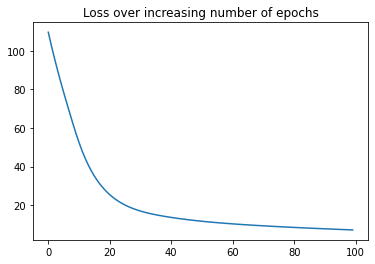

In [279]:
losses = []
for epoch in range(100):
    W, loss = update_weights(x,y,W,0.01)
    losses.append(loss)
plt.plot(losses)
plt.title('Loss over increasing number of epochs')

In [280]:
#print out the learned weights
W

[array([[ 0.70770466, -0.5112964 ,  0.496056  ],
        [-0.14375344, -0.3694686 ,  0.0040059 ]], dtype=float32),
 array([-0.86639124,  0.6364053 , -0.6169661 ], dtype=float32),
 array([[ 4.357959  ],
        [-0.49664417],
        [ 3.1768014 ]], dtype=float32),
 array([3.3182478], dtype=float32)]

In [281]:
# try predicting x_test again--did it learning anything?
x_test = np.array([[1,4],[5,4]])

pre_hidden = np.dot(x_test,W[0]) + W[1]
hidden = 1/(1+np.exp(-pre_hidden))
out = np.dot(hidden, W[2]) + W[3]

out

array([[6.13505272],
       [9.93946044]])

# Simple network in PyTorch for comparison


In [282]:
import torch
import torch.nn as nn

In [283]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# register the tensors to GPU memory
X = torch.tensor(x).float()
Y = torch.tensor(y).float()

X = X.to(device)
Y = Y.to(device)

In [284]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()  # what does 'super' do here? 
        self.input_to_hidden_layer = nn.Linear(2,8) # what are the 2 and 8 here referring to?
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear(8,1) # what are 8 and 1?
    def forward(self, x):
        x = self.input_to_hidden_layer(x)
        x = self.hidden_layer_activation(x)
        x = self.hidden_to_output_layer(x)
        return x

mynet = MyNeuralNet().to(device)  # what does this do?

In [285]:
loss_func = nn.MSELoss() # try some other options here...


In [286]:
_Y = mynet(X)
loss_value = loss_func(_Y,Y)
print(loss_value)


tensor(179.7070, grad_fn=<MseLossBackward0>)


In [287]:
from torch.optim import SGD
opt = SGD(mynet.parameters(), lr = 0.001)

In [288]:
loss_history = []
# what does the '_' do here?
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func(mynet(X),Y)
    loss_value.backward()
    opt.step()
    # must convert back to numpy for plot to work
    loss_history.append(loss_value.detach().numpy())

Text(0, 0.5, 'loss value')

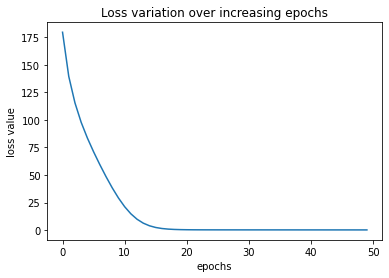

In [289]:


plt.plot(loss_history)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')

In [290]:
# try inference on this model
# remember, x_test = np.array([[1,4],[5,4]]) so output should be [5, 9]

X_test = torch.tensor(x_test)

X_test = X_test.float().to(device)
Y_test = mynet(X_test)
print (Y_test)

tensor([[5.2941],
        [9.0359]], grad_fn=<AddmmBackward0>)


#Dataloaders
While the dataset above is quite small, dataloaders are crtiical for large datasets, like images. Here is an example for the above problem, but using dataloaders.

In [291]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
ds = MyDataset(X, Y)

<ipython-input-291-30435f14e6ac>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x).float()
<ipython-input-291-30435f14e6ac>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y).float()


In [292]:
# we need to redefine our class to include the dataloader

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

# here is the dataloader!
dl = DataLoader(ds, batch_size=2, shuffle=True)

In [293]:
# and we need to add another level of looping for the batches

import time
loss_history = []
start = time.time()
for _ in range(50):
    for data in dl:
        x, y = data
        opt.zero_grad()
        loss_value = loss_func(mynet(x),y)
        loss_value.backward()
        opt.step()
        loss_history.append(loss_value)
end = time.time()
print(end - start)


0.10750198364257812


In [294]:
# same inference cell copied down
# remember, x_test = np.array([[1,4],[5,4]]) so output should be [5, 9]

X_test = torch.tensor(x_test)

X_test = X_test.float().to(device)
Y_test = mynet(X_test)
print (Y_test)

tensor([[5.4378],
        [9.0911]], grad_fn=<AddmmBackward0>)
